In [ ]:
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from src.utils import Config, ImageProcessor
from src.data_preparation import DataHandling, LoaderFactory, load_df_from_pickle, save_df_to_pickle, load_df_from_pickle
from src.vis import visualize_axial_slice, visualize_coronal_slice, dash_plot_artifact, display_patient_coronal
from src.model_manager import ModelLoader
import pandas as pd
import os


In [ ]:

config_file = 'src/config.json'
config = Config(config_file)
data_handler = DataHandling(
    config.artifact_dir_dash,
    train_mode=config.train_mode,
    target_mode=config.target_mode,
    external_centers=config.external_centers,
    train_percent=config.train_percent,
    val_percent=config.val_percent,
    test_percent=config.test_percent
    )


# train_files = data_handler.get_data_split('train')
# val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')


--------
# Creating atricatual df

In [ ]:

# config_file = 'src/config.json'
# config = Config(config_file)
# data_handler = DataHandling(
#     config.artifact_dir_dash,
#     train_mode=config.train_mode,
#     target_mode=config.target_mode,
#     external_centers=config.external_centers,
#     train_percent=config.train_percent,
#     val_percent=config.val_percent,
#     test_percent=config.test_percent
#     )


# # train_files = data_handler.get_data_split('train')
# # val_files = data_handler.get_data_split('val')
# test_files = data_handler.get_data_split('test')


In [ ]:


# loader_factory = LoaderFactory(
#     train_files=_,
#     val_files=_,
#     test_files=test_files,
#     patch_size=config.patch_size,
#     spacing=config.spacing,
#     spatial_size=config.spatial_size,
#     normalize=config.normalize
#     )


# # Get the DataLoader for each dataset type
# test_loader = loader_factory.get_loader('test', batch_size=config.batch_size['test'], num_workers=config.num_workers['test'], shuffle=False)
# test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
# image_files = [file_info['image'] for file_info in test_files]
# target_files = [file_info['target'] for file_info in test_files]

# # Create a list of dictionaries containing the patient data
# patient_data = [{
#     'name': os.path.splitext(name_pair[0])[0],
#     'image': image_path,
#     'target': target_path
# } for name_pair, image_path, target_path in zip(test_name, image_files, target_files)]

# # Create a DataFrame from the list of dictionaries
# df = pd.DataFrame(patient_data)
# hint = 'dl4_23'  # Replace with the actual hint
# n = 85  # You can choose any valid slice index

# # Create an instance of ImageProcessor
# processor = ImageProcessor(config.dash_output_dir, config.nac_factor_ga, config.mac_factor_ga, hint)

# # Assuming df_patients and test_files are already defined
# df = processor.load_and_store_images_to_df(df, test_files)

In [ ]:

# # Example usage
# # df = your_dataframe_here
# save_df_to_pickle(df)

## Loading Artifactual df

In [ ]:
import pandas as pd
artifactual_df_path = '/students/2023-2024/master/Shahpouri/DATA/Artifact_data.pkl'
# Example usage
df = load_df_from_pickle(artifactual_df_path)

df.head()

In [ ]:
selected_patient = '004254_C4_SH_'

# Plotting Artifactual data

In [ ]:
import streamlit as st
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
def get_patient_data(patient_name):
    patient_data = df[df['name'] == patient_name]
    if patient_data.empty:
        return None, None, None, None
    image = patient_data['image_matrix'].values[0]
    target = patient_data['target_matrix'].values[0]
    dl_image = patient_data['dl_image_matrix'].values[0]
    difference_image = patient_data['difference_matrices'].values[0]
    return image, target, dl_image, difference_image


image, target, dl_image, difference_image = get_patient_data(selected_patient)

# def normalize_image(image):
#     """Normalize image data to the range [0, 255] for display."""
#     image_min, image_max = np.min(image), np.max(image)
#     if image_max == image_min:
#         return np.zeros_like(image, dtype=np.uint8)
#     normalized = (image - image_min) / (image_max - image_min) * 255
#     return normalized.astype(np.uint8)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
def matplotlib_artifact(image, target, dl_image, difference_image, n, cmp="gist_yarg"):
    """
    Display medical images for a patient: input, target, deep learning output, and the difference.
    """
    colors = [(0.00, "red"), (0.40, "white"), (0.8, "white"), (1.00, "blue")]
    cmap_name = 'custom_seismic_more_white'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)

    fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'wspace':0.3, 'hspace':0})

    # Turn off axes
    for ax in axs:
        ax.axis('off')

    # Configure vmin and vmax for each image type
    nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.9))
    mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.9))
    dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 99.9))

    # Input Image
    input_slice = np.rot90(image[:, n, :])
    im0 = axs[0].imshow(input_slice, cmap=cmp, vmin=nac_display_range[0], vmax=nac_display_range[1])
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    # Target Image
    target_slice = np.rot90(target[:, n, :])
    im1 = axs[1].imshow(target_slice, cmap=cmp, vmin=mac_display_range[0], vmax=mac_display_range[1])
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    # DL Image
    dl_slice = np.rot90(dl_image[:, n, :])
    im2 = axs[2].imshow(dl_slice, cmap=cmp, vmin=dl_display_range[0], vmax=dl_display_range[1])
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    # Difference Image
    difference_slice = np.rot90(difference_image[:, n, :])
    im3 = axs[3].imshow(difference_slice, cmap=cm, vmin=-1, vmax=1)
    fig.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)

    plt.show()

# Example data for testing
n = 85  # Example slice index, replace as needed
matplotlib_artifact(image, target, dl_image, difference_image, n)


In [ ]:
custom_colorscale = [
    [0.0, "red"],
    [0.4, "white"],
    [0.8, "white"],
    [1.0, "blue"]
]
import plotly.graph_objects as go
from plotly.subplots import make_subplots


high_contrast_greys = [
    [0.0, 'rgb(255, 255, 255)'],  # Pure white background
    [0.3, 'rgb(40, 40, 40)'],  # Dark grey
    [1.0, 'rgb(0, 0, 0)']         # Pure black for hot spots
]


def dash_plot_artifact(image, target, dl_image, difference_image, n):
    """
    Display medical images for a patient: input, target, deep learning output, and the difference.
    """
    # Ensure the slice index n is within the bounds of the image dimensions
    n = min(n, image.shape[1] - 1)

    # Extract the nth slice without any rotation or normalization
    input_slice, target_slice, dl_slice, difference_slice = rotate_and_flip(image, target, dl_image, difference_image, n)

    # Create a subplot grid in Plotly
    fig = make_subplots(rows=1, cols=4, subplot_titles=("Input", "Target", "DL Output", "Difference"))

    # Input Image
    fig.add_trace(go.Heatmap(z=input_slice, colorscale=high_contrast_greys, showscale=False), row=1, col=1)

    # Target Image
    fig.add_trace(go.Heatmap(z=target_slice, colorscale=high_contrast_greys, showscale=False), row=1, col=2)

    # DL Image
    fig.add_trace(go.Heatmap(z=dl_slice, colorscale=high_contrast_greys, showscale=False), row=1, col=3)

    # Difference Image
    fig.add_trace(go.Heatmap(z=difference_slice, colorscale=custom_colorscale, showscale=False), row=1, col=4)

    fig.show()

# Example usage in your Jupyter Notebook
n = 85  # Example slice index, replace as needed
dash_plot_artifact(image, target, dl_image, difference_image, n)




In [ ]:

# selected_patient = '001468_C1_RZ_'
# def get_patient_data(patient_name):
#         patient_data = df[df['name'] == patient_name]
#         if patient_data.empty:
#             return None, None, None, None
#         image = patient_data['image_matrix'].values[0]
#         target = patient_data['target_matrix'].values[0]
#         dl_image = patient_data['dl_image_matrix'].values[0]
#         difference_image = patient_data['difference_matrices'].values[0]
#         return image, target, dl_image, difference_image

# image, target, dl_image, difference_image = get_patient_data(selected_patient)

# if image is not None:
#     # Add a slider for slice index selection
#     num_slices = image.shape[1]  # Assuming images are 3D arrays with shape (x, y, z)
    
#     # Display the selected slice using the provided function
#     dash_plot_artifact(image, target, dl_image, difference_image, slice_index=85)
# else:
#     print(f"No data found for patient {selected_patient}.")

In [ ]:
# import numpy as np

# # Function to display images for a sample patient
# def plot_sample_patient(df, patient_name, n):
#     # Find the patient data in the DataFrame
#     patient_data = df[df['name'] == patient_name]
    
#     if patient_data.empty:
#         print(f"No data found for patient {patient_name}")
#         return
    
#     # Extract the image matrices
#     image = patient_data['image_matrix'].values[0]
#     target = patient_data['target_matrix'].values[0]
#     dl_image = patient_data['dl_image_matrix'].values[0]
#     difference_image = patient_data['difference_matrices'].values[0]
    


#     # Display the images using the provided function
#     display_patient_coronal(patient_name, image, target, dl_image, difference_image, n, cmp="gist_yarg")

# # Choose a slice index for visualization
# n = 85  # You can choose any valid slice index
# sample_patient_name = '004254_C4_SH_'  # Replace with an actual patient name from your DataFrame
# plot_sample_patient(df, sample_patient_name)


In [ ]:
# import nibabel as nib
# hint = 'dl4_23'
# nac_factor=2
# mac_factor=5
# patient_names = [name_pair[0] for name_pair in test_name]

# i = 1
# for file_info, name in zip(test_files, patient_names):
#     image_path = file_info['image']
#     target_path = file_info['target']
 
#     # Remove any potential file extensions from patient_folder_name_image
#     patient_folder_name_image = os.path.splitext(name)[0]
#     dl_image_path = find_dl_image_path(config.artifact_output_dir, patient_folder_name_image, hint)
#     if dl_image_path is None:
#         continue
#     try:
#         image = (nib.load(image_path).get_fdata()) * nac_factor
#         target = (nib.load(target_path).get_fdata()) * mac_factor
#         dl_image = (nib.load(dl_image_path).get_fdata()) * mac_factor
#     except Exception as e:
#         print(f"Error loading or processing images for {patient_folder_name_image}: {e}")
#         continue

#     difference_image = (target - dl_image) / mac_factor
#     # print(np.max(difference_image), np.min(difference_image))
#     difference_image = np.clip(difference_image, -1, 1)

    
#     n = 85

#     patient_name = patient_names[1]
#     display_patient_coronal(patient_name, image, target, dl_image, difference_image, n, cmp ="gist_yarg")
#     i +=1
#     if i == 2:
#         break

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.pyplot as plt
# import numpy as np

# def display_patient_coronal(patient_folder_name, image, target, dl_image, difference_image, n, cmp="gray"):
#     """
#     Display medical images for a patient: input, target, deep learning output, and the difference.
#     """
#     colors = [(0.00, "red"), (0.40, "white"), (0.80, "white"), (1.00, "blue")]
#     cmap_name = 'custom_seismic_more_white'
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)

#     fig, axs = plt.subplots(1, 4, figsize=(12, 6), gridspec_kw={'wspace': 0, 'hspace': 0})
#     cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

#     # Turn off axes
#     for ax in axs:
#         ax.axis('off')

#     # Configure vmin and vmax for each image type
#     nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.9))
#     mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.9))
#     dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 99.9))

#     # Input Image
#     input_slice = np.rot90(image[:, n, :])
#     im = axs[0].imshow(input_slice, cmap=cmp, vmin=nac_display_range[0], vmax=nac_display_range[1])

#     # Target Image
#     axs[1].set_title(patient_folder_name)
#     target_slice = np.rot90(target[:, n, :])
#     axs[1].imshow(target_slice, cmap=cmp, vmin=mac_display_range[0], vmax=mac_display_range[1])

#     # DL Image
#     dl_slice = np.rot90(dl_image[:, n, :])
#     axs[2].imshow(dl_slice, cmap=cmp, vmin=dl_display_range[0], vmax=dl_display_range[1])

#     # Difference Image
#     difference_slice = np.rot90(difference_image[:, n, :])
#     im_diff = axs[3].imshow(difference_slice, cmap=cm, vmin=-1, vmax=1)

#     # Add colorbars
#     fig.colorbar(im, ax=axs[0], orientation='vertical')
#     fig.colorbar(im, ax=axs[1], orientation='vertical')
#     fig.colorbar(im, ax=axs[2], orientation='vertical')
#     fig.colorbar(im_diff, ax=axs[3], orientation='vertical')

#     plt.show()


# n = 50

# display_patient_coronal(patient_folder_name, image, target, dl_image, difference_image, n)


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

def display_patient_coronal(patient_folder_name, image, target, dl_image, difference_image, n, cmp="gray"):
    """
    Display medical images for a patient: input, target, deep learning output, and the difference.
    """
    colors = [(0.00, "orange"), (0.40, "white"), (0.8, "white"), (1.00, "blue")]
    cmap_name = 'custom_seismic_more_white'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)

    fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'wspace':0.3, 'hspace':0})

    # Turn off axes
    for ax in axs:
        ax.axis('off')

    # Configure vmin and vmax for each image type
    nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.9))
    mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.9))
    dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 99.9))

    # Input Image
    input_slice = np.rot90(image[:, n, :])
    im0 = axs[0].imshow(input_slice, cmap=cmp, vmin=nac_display_range[0], vmax=nac_display_range[1])
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    # Target Image
    axs[1].set_title(patient_folder_name)
    target_slice = np.rot90(target[:, n, :])
    im1 = axs[1].imshow(target_slice, cmap=cmp, vmin=mac_display_range[0], vmax=mac_display_range[1])
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    # DL Image
    dl_slice = np.rot90(dl_image[:, n, :])
    im2 = axs[2].imshow(dl_slice, cmap=cmp, vmin=dl_display_range[0], vmax=dl_display_range[1])
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    # Difference Image
    difference_slice = np.rot90(difference_image[:, n, :])
    im3 = axs[3].imshow(difference_slice, cmap=cm, vmin=-1, vmax=1)
    fig.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)

    plt.show()



In [ ]:
from utils import find_dl_image_path, normalize_data
# from vis import display_patient_coronal


hint = "dl_final_3_29"
hint = 'gamodel_3_18_onfdg'
hint = 'dl4_23'
hint = 'adcm_4_26'
hint = "final_4_26"
hint = 'comb_4_5_onfdg'
nac_factor=3
mac_factor=7

i = 1
for file_info, name_pair in zip(test_files, test_name):
    image_path = file_info['image']
    target_path = file_info['target']
    patient_folder_name_image, _ = name_pair

    dl_image_path = find_dl_image_path(fdg_output_dir, patient_folder_name_image, hint)
    if dl_image_path is None:
        print(f"No DL image found for {patient_folder_name_image}")
        continue

    # image = normalize_data(nib.load(image_path).get_fdata())
    # target = normalize_data(nib.load(target_path).get_fdata())
    # dl_image = normalize_data(nib.load(dl_image_path).get_fdata())

    image = (nib.load(image_path).get_fdata()) * nac_factor
    target = (nib.load(target_path).get_fdata()) * mac_factor
    dl_image = (nib.load(dl_image_path).get_fdata()) * mac_factor
    difference_image = (target - dl_image) 
    # print(np.max(difference_image), np.min(difference_image))
    difference_image = np.clip(difference_image, -1, 1)


    n = 90
    # n = 85
    # n = 90
    # n = 108
    # n = 100
    # n = 115
    
    display_patient_coronal(patient_folder_name_image, image, target, dl_image, difference_image, n, cmp ="jet")
    # i +=1
    # if i == 20:
    #     break


-----------

# Loss plots

In [ ]:
from src.utils import find_last_saved_model, parse_loss_values

# log_filename = 'log_2_26_8_17.txt' # saved on hard
# log_filename = 'log_3_4_12_4.txt' # saved on hard
# log_filename = 'log_3_4_12_41.txt' # saved on hard
# log_filename = 'log_3_18.txt'
log_filename = 'log_3_27_8_47.txt' # Tuned for fdg
# log_filename = 'log_3_28_6_8.txt'
# log_filename = 'log_3_28_10_41.txt'
# log_filename = 'log_3_28_20_48.txt' # Tuned for itself on ga
# log_filename = 'log_3_29_6_54.txt' # adcm final model for 11 april is here
log_filename = 'log_4_6_8_55.txt' # Ghabl az relu gozashtan hast, structure fargh dare.
# log_filename = 'log_4_12_23_41.txt' # adcm structure modelesh fargh dare yadam nist male chie ghaziash
# log_filename = 'log_4_13_11_32.txt' # adcm norm 100
log_filename = 'log_4_26_21_24.txt' # adcm norm 50
log_filename = 'log_4_17_19_29.txt' # Ga, new structure. editesh kardam payini ro ezaf kardam behesh.

log_filepath = config.log_dir + '/'+ log_filename


In [ ]:

from src.data_preparation import parse_log_file

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
import re

# Parse the log file into a single DataFrame
df_losses = parse_log_file(log_filepath)

# Display the parsed data
df_losses

In [ ]:
# Assuming df is your DataFrame

df_losses_path = '/students/2023-2024/master/Shahpouri/DATA/imcm_loss.pkl'



In [ ]:


# # Example usage
# # df = your_dataframe_here
# save_df_to_pickle(df_losses, df_losses_path)

In [ ]:

# Example usage
df = load_df_from_pickle(df_losses_path)

df.head()

In [ ]:

# Group by 'Epoch' and 'Type' to get average loss per epoch
df_avg_losses = df_losses.groupby(['Epoch', 'Type']).mean().reset_index()

# Separate the data for plotting
train_losses = df_avg_losses[df_avg_losses['Type'] == 'Training']
val_losses = df_avg_losses[df_avg_losses['Type'] == 'Validation']

# Create line plot for Training and Validation losses
train_trace = go.Scatter(
    x=train_losses['Epoch'],
    y=train_losses['Loss'],
    mode='lines',
    name='Training Loss',
    line=dict(color='blue')
)

val_trace = go.Scatter(
    x=val_losses['Epoch'],
    y=val_losses['Loss'],
    mode='lines',
    name='Validation Loss',
    line=dict(color='red')
)

layout = go.Layout(
    title='Training and Validation Losses',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    hovermode='closest'
)

fig = go.Figure(data=[train_trace, val_trace], layout=layout)
fig.show()


--------
# box plots

In [ ]:
# import pandas as pd
# # Load the data
# df_combined = pd.read_csv('/students/2023-2024/master/Shahpouri/DL_PET/Results/metric_data_ga.csv')

# # Replace 'Multi-Center' with 'IMCM'
# df_combined['Dataset'] = df_combined['Dataset'].replace('Multi-Center', 'IMCM')
# df_combined['Center_Group'] = df_combined['Center'].apply(lambda x: 'Internal' if x in ['C1', 'C2', 'C3', 'C4', 'C6', 'C7'] else 'External')
# df_combined = df_combined.drop(columns=['Absolure Relative Error (SUV%)'])
# # Save the updated DataFrame back to CSV
# updated_csv_path = '/students/2023-2024/master/Shahpouri/DATA/metric_data_ga.csv'

# df_combined.to_csv(updated_csv_path, index=False)

# updated_csv_path


In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Load the data (replace with your correct path)
ga_df = pd.read_csv('/students/2023-2024/master/Shahpouri/DATA/metric_data_ga.csv')  # Replace with the correct path

# Define metrics names and titles for the plots
metrics_info = {
    'Mean Error (SUV)': 'ME',
    'Mean Absolure Error (SUV)': 'MAE',  # Correct this to 'Mean Absolute Error (SUV)' if it's a typo in the data
    'Relative Error (SUV%)': 'RE(%)',
    'Root Mean Squared Error': 'RMSE',
    'Peak Signal-to-Noise Ratio': 'PSNR',
    'Structual Similarity Index': 'SSIM'
}

dataset_labels = ['IMCM', 'ADCM']  # Labels for datasets
center_groups = ['Internal', 'External']  # Center groups
colors = ['cornflowerblue', 'royalblue', 'sandybrown', 'coral']  # Colors for each combination

# Create the boxplot for each metric
for metric, subtitle in metrics_info.items():
    fig = go.Figure()
    color_idx = 0  # Initialize color index
    for dataset in dataset_labels:
        for center_group in center_groups:
            filtered_data = ga_df[(ga_df['Dataset'] == dataset) & (ga_df['Center_Group'] == center_group)]
            fig.add_trace(go.Box(
                y=filtered_data[metric],
                name=f"{dataset} ({center_group})",
                boxmean=True,
                marker_color=colors[color_idx],
                boxpoints='suspectedoutliers'  # Display suspected outliers
            ))
            color_idx += 1  # Move to the next color
    
    # Update layout
    fig.update_layout(
        yaxis_title=subtitle,
        boxmode='group',  # group together boxes of the different traces for each value of x
        showlegend=True,
        plot_bgcolor='white',  # Set background to white
        paper_bgcolor='white',  # Set the paper background to white
        margin=dict(l=50, r=20, t=20, b=50),  # Adjust margins for tighter layout
        height=400,  # Larger height
        width=600,  # Larger width
        xaxis=dict(
            linecolor='black',  # Gray axis lines
            tickvals=[0.3, 2.5],  # Custom tick positions to separate dataset groups
            ticktext=dataset_labels,
            tickangle=45
        ),
        yaxis=dict(
            linecolor='black',  # Gray axis lines
            tickangle=0
        )
    )

    fig.show()  # Display the plot


In [ ]:
import pandas as pd
# Load the data
df_fdg = pd.read_csv('/students/2023-2024/master/Shahpouri/DL_PET/Results/metric_data_fdg.csv')

# Replace 'Multi-Center' with 'IMCM'
df_fdg['Dataset'] = df_fdg['Dataset'].replace('Multi-Center', 'IMCM')
df_fdg['Center_Group'] = df_fdg['Center'].apply(lambda x: 'Internal' if x in ['C0'] else 'External')
df_fdg = df_fdg.drop(columns=['Absolure Relative Error (SUV%)'])
# Save the updated DataFrame back to CSV
updated_csv_path = '/students/2023-2024/master/Shahpouri/DATA/metric_data_fdg.csv'

df_fdg.to_csv(updated_csv_path, index=False)

df_fdg

In [ ]:
# Check the column names in the DataFrame
print(ga_df.columns)


In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import exposure

# Load NIfTI file
nifti_file_dl = '/students/2023-2024/master/Shahpouri/GA_OUTPUT/007057_C5_RJ_/007057_C5_RJ__dl4_23.nii.gz'

img = nib.load(nifti_file_dl)
data = img.get_fdata()

# Normalize the data for better visualization
data = (data - np.min(data)) / (np.max(data) - np.min(data))

skip_slices = 60
images = []

for i in range(skip_slices, data.shape[1] - skip_slices):
    slice_img = np.rot90(data[:, i, :])
    
    # Apply auto contrast adjustment
    slice_img = exposure.equalize_adapthist(slice_img)

    # Convert to 8-bit image
    slice_img = (255 * slice_img).astype(np.uint8)
    fig, ax = plt.subplots()
    ax.imshow(slice_img, cmap='viridis')

    plt.axis('off')
    fig.canvas.draw()

    # Convert plot to image
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    images.append(image)
    plt.close(fig)

# Append the reversed images to create a forward and backward effect
images = images + images[::-1]

# Save images as GIF
output_path = '/students/2023-2024/master/Shahpouri/DL_PET/info/animation2.gif'
imageio.mimsave(output_path, images, fps=10, loop=0)

print(f'Saved GIF: {output_path}')


In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import exposure

def process_nifti_file(nifti_file, output_dir, skip_slices=60):
    # Load NIfTI file
    img = nib.load(nifti_file)
    data = img.get_fdata()

    # Normalize the data for better visualization
    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    # Extract slices and create images
    images = []
    for i in range(skip_slices, data.shape[1] - skip_slices):
        # Rotate and normalize the slice
        slice_img = np.rot90(data[:, i, :])
        
        # Apply auto contrast adjustment
        slice_img = exposure.equalize_adapthist(slice_img)

        # Convert to 8-bit image
        slice_img = (255 * slice_img).astype(np.uint8)
        
        # Append to image list
        fig, ax = plt.subplots()
        ax.imshow(slice_img, cmap='jet')
        plt.axis('off')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close(fig)

    # Create the output filename
    base_name = os.path.basename(nifti_file).replace('.nii.gz', '.gif')
    output_path = os.path.join(output_dir, base_name)

    # Save images as GIF
    imageio.mimsave(output_path, images, fps=10)
    print(f'Saved GIF: {output_path}')

    return output_path
def process_all_nifti_files(main_folder, output_dir, skip_slices=60):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Walk through the main folder and process each NIfTI file
    for root, dirs, files in os.walk(main_folder):
        for file in files:
            if file.endswith('dl4_23.nii.gz'):
                nifti_file_path = os.path.join(root, file)
                output_path_gif = process_nifti_file(nifti_file_path, output_dir, skip_slices)

# Main folder and output directory
main_folder = '/students/2023-2024/master/Shahpouri/GA_OUTPUT/'
output_dir = '/students/2023-2024/master/Shahpouri/DL_PET/info/'

# Process all NIfTI files
process_all_nifti_files(main_folder, output_dir)


In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import exposure

def process_nifti_file(nifti_file, output_dir, skip_slices=60):
    # Load NIfTI file
    img = nib.load(nifti_file)
    data = img.get_fdata()

    # Normalize the data for better visualization
    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    # Extract slices and create images
    images = []
    for i in range(skip_slices, data.shape[1] - skip_slices):
        # Rotate and normalize the slice
        slice_img = np.rot90(data[:, i, :])
        
        # Apply auto contrast adjustment
        slice_img = exposure.equalize_adapthist(slice_img)

        # Convert to 8-bit image
        slice_img = (255 * slice_img).astype(np.uint8)
        
        # Append to image list
        fig, ax = plt.subplots()
        ax.imshow(slice_img, cmap='jet')
        plt.axis('off')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        images.append(image)
        plt.close(fig)

    # Create the output filename
    base_name = os.path.basename(nifti_file).replace('.nii.gz', '.gif')
    output_path = os.path.join(output_dir, base_name)

    # Save images as GIF
    imageio.mimsave(output_path, images, fps=10)
    print(f'Saved GIF: {output_path}')

    return output_path

def find_matching_files(info_folder, main_folder):
    # Dictionary to store pairs of original and new animation paths
    animation_pairs = {}

    # Extract the first part of each filename in the info folder
    info_files = os.listdir(info_folder)
    name_roots = [file.split('_dl4_23.gif')[0] for file in info_files if file.endswith('_dl4_23.gif')]

    print(name_roots)
    # Find matching files in the main folder and create animations
    for name in name_roots:
        main_file_path = os.path.join(main_folder, f'{name}.nii.gz')
        if os.path.exists(main_file_path):
            output_path_gif = process_nifti_file(main_file_path, info_folder)  # Pass the directory, not the file path
            animation_pairs[name] = {
                'DL': os.path.join(info_folder, f'{name}_dl4_23.gif'),
                'MAC': output_path_gif
            }

    return animation_pairs

# Folders
info_folder = '/students/2023-2024/master/Shahpouri/DL_PET/info/'
main_folder = '/students/2023-2024/master/Shahpouri/DATA/Ga-PET/MAC/'

# Find matching files and create animations
animation_pairs = find_matching_files(info_folder, main_folder)

# Print the dictionary of animation pairs
print(animation_pairs)


In [ ]:
import os
from PIL import Image

def combine_gifs(pair_gif_paths, output_path):
    dl_gif = Image.open(pair_gif_paths['DL'])
    mac_gif = Image.open(pair_gif_paths['MAC'])
    
    dl_frames = []
    mac_frames = []

    while True:
        try:
            dl_frames.append(dl_gif.copy())
            mac_gif.seek(dl_gif.tell())
            mac_frames.append(mac_gif.copy())
            dl_gif.seek(dl_gif.tell() + 1)
        except EOFError:
            break

    combined_frames = []
    for dl_frame, mac_frame in zip(dl_frames, mac_frames):
        combined_width = dl_frame.width + mac_frame.width
        combined_height = max(dl_frame.height, mac_frame.height)
        
        combined_frame = Image.new('RGB', (combined_width, combined_height))
        combined_frame.paste(dl_frame, (0, 0))
        combined_frame.paste(mac_frame, (dl_frame.width, 0))
        
        combined_frames.append(combined_frame)

    combined_frames[0].save(output_path, save_all=True, append_images=combined_frames[1:], duration=100, loop=0)
    print(f'Saved combined GIF: {output_path}')

def create_combined_gifs(animation_pairs, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    combined_gif_paths = []
    for name, paths in animation_pairs.items():
        output_path = os.path.join(output_dir, f'{name}_combined.gif')
        combine_gifs(paths, output_path)
        combined_gif_paths.append(output_path)
    return combined_gif_paths

def concatenate_gifs(gif_paths, output_path):
    all_frames = []
    for gif_path in gif_paths:
        gif = Image.open(gif_path)
        while True:
            try:
                all_frames.append(gif.copy())
                gif.seek(gif.tell() + 1)
            except EOFError:
                break

    all_frames[0].save(output_path, save_all=True, append_images=all_frames[1:], duration=100, loop=0)
    print(f'Saved concatenated GIF: {output_path}')

# Paths
info_folder = '/students/2023-2024/master/Shahpouri/DL_PET/info/'
output_combined_dir = '/students/2023-2024/master/Shahpouri/DL_PET/combined/'
final_output_path = '/students/2023-2024/master/Shahpouri/DL_PET/final_animation.gif'


# Create combined GIFs
combined_gif_paths = create_combined_gifs(animation_pairs, output_combined_dir)

# Concatenate all combined GIFs into one final GIF
concatenate_gifs(combined_gif_paths, final_output_path)

# Print the dictionary of animation pairs
print(animation_pairs)


----------
# TAB Correcting ASC with model

In [2]:
from src.utils import Config
from src.data_preparation import LoaderFactory
import os

In [3]:
import json
config_file = 'src/config.json'
config = Config(config_file)
# Load JSON file
with open('Results/test_files.json', 'r') as f:
    test_files = json.load(f)

Requested device: cuda:0
CUDA is not available. Switching to CPU.


In [6]:
test_name = [
    (
        os.path.splitext(os.path.splitext(os.path.basename(file_info['image']))[0])[0],
        os.path.splitext(os.path.splitext(os.path.basename(file_info['target']))[0])[0]
    )
    for file_info in test_files
]
test_name

[('007026_C5_RJ_', '007026_C5_RJ_'),
 ('007035_C5_RJ_', '007035_C5_RJ_'),
 ('007037_C5_RJ_', '007037_C5_RJ_'),
 ('007038_C5_RJ_', '007038_C5_RJ_'),
 ('007042_C5_RJ_', '007042_C5_RJ_'),
 ('007043_C5_RJ_', '007043_C5_RJ_'),
 ('007046_C5_RJ_', '007046_C5_RJ_'),
 ('007051_C5_RJ_', '007051_C5_RJ_'),
 ('007057_C5_RJ_', '007057_C5_RJ_'),
 ('007058_C5_RJ_', '007058_C5_RJ_'),
 ('007066_C5_RJ_', '007066_C5_RJ_'),
 ('007067_C5_RJ_', '007067_C5_RJ_'),
 ('001404_C1_RZ_', '001404_C1_RZ_'),
 ('001405_C1_RZ_', '001405_C1_RZ_'),
 ('001407_C1_RZ_', '001407_C1_RZ_'),
 ('001641_C1_RZ_', '001641_C1_RZ_'),
 ('001097_C1_RZ_', '001097_C1_RZ_'),
 ('001216_C1_RZ_', '001216_C1_RZ_'),
 ('001595_C1_RZ_', '001595_C1_RZ_'),
 ('002360_C2_IM_', '002360_C2_IM_'),
 ('002361_C2_IM_', '002361_C2_IM_'),
 ('002414_C2_IM_', '002414_C2_IM_'),
 ('003439_C3_KH_', '003439_C3_KH_'),
 ('003241_C3_KH_', '003241_C3_KH_'),
 ('003273_C3_KH_', '003273_C3_KH_'),
 ('003410_C3_KH_', '003410_C3_KH_'),
 ('003208_C3_KH_', '003208_C3_KH_'),
 

In [7]:
loader_factory = LoaderFactory(
    train_files=_,
    val_files=_,
    test_files=test_files,
    patch_size=config.patch_size,
    spacing=config.spacing,
    spatial_size=config.spatial_size,
    normalize=config.normalize
    )


# Get the DataLoader for each dataset type
test_loader = loader_factory.get_loader('test', batch_size=config.batch_size['test'], num_workers=config.num_workers['test'], shuffle=False)


In [8]:
from src.model_manager import ModelLoader
import torch
# Searching for model.
model_path =  'Results/model_4_24_23_17.pth'
model_loader = ModelLoader(config)
model = model_loader.call_model()


# Loading model in eval mode.
if os.path.exists(model_path):
    print(f"Model in {model_path} is loaded.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model in {model_path} not found.")

Starting a dynunet model training.
Model in Results/model_4_24_23_17.pth is loaded.


In [9]:
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import Compose
# from src.vis import model_visualize_coronal
import torch
import os
from monai.transforms import Compose, Invertd, SaveImaged
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt

def model_visualize_coronal(data, predict, n, title, cm, Norm=False):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Adjusted for three plots

    titles = ["Input", "Ground_truth", title]
    slices = [
        np.rot90(data["image"][0, :, n, :]),
        np.rot90(data["target"][0, :, n, :]),
        np.rot90(predict.detach().cpu()[0, :, n, :])
    ]

    vmin, vmax = None, None
    if Norm:
        # Find the min and max of all colors for use in setting the color scale.
        vmin = min(slice.min() for slice in slices)
        vmax = max(slice.max() for slice in slices)

    # Display the images with color bars
    for ax, slice, title in zip(axes, slices, titles):
        img = ax.imshow(slice, cmap=cm, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
        fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


def rotate_and_flip(image, target, dl_image, difference_image=None, n=None):
    """
    Rotate and flip the images for correct display orientation.
    """
    input_slice = np.rot90(image[:, n, :])
    target_slice = np.rot90(target[:, n, :])
    dl_slice = np.rot90(dl_image[:, n, :])

    # Flip the slices vertically to match Bokeh's default origin
    input_slice = np.flipud(input_slice)
    target_slice = np.flipud(target_slice)
    dl_slice = np.flipud(dl_slice)

    if difference_image is not None:
        difference_slice = np.rot90(difference_image[:, n, :])
        difference_slice = np.flipud(difference_slice)
    else:
        difference_slice = None

    return input_slice, target_slice, dl_slice, difference_slice


Starting a dynunet model training.
Model in Results/model_4_24_23_17.pth is loaded.


100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


2024-08-10 10:05:46,019 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/DASH_OUTPUT/007026_C5_RJ_/007026_C5_RJ__dash.nii.gz


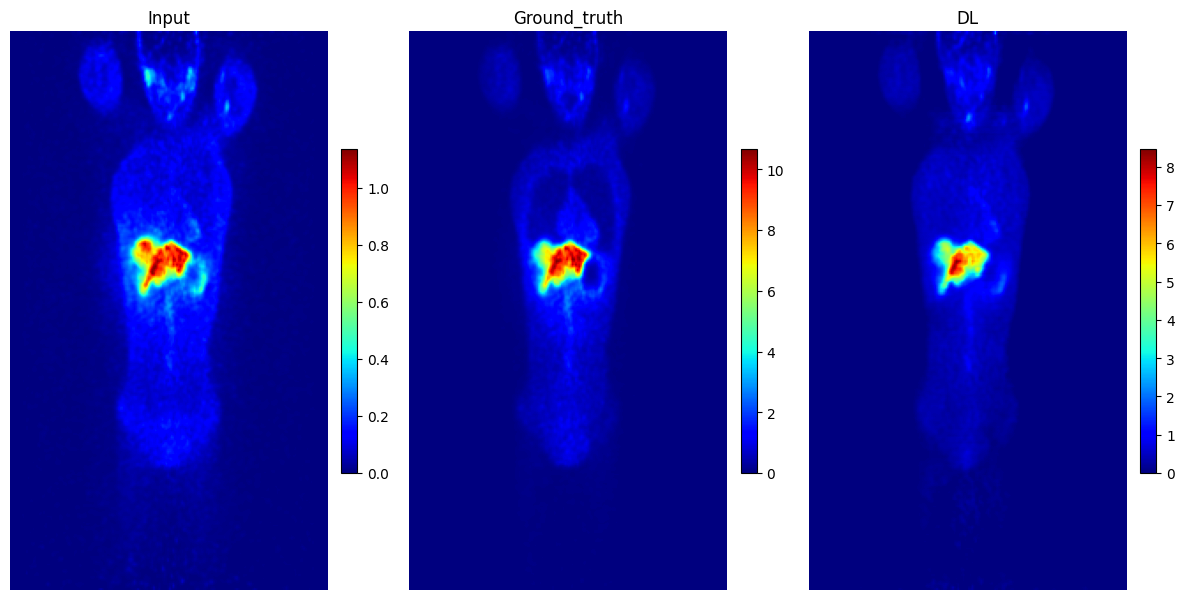

In [10]:
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import Compose, Invertd, SaveImaged
import torch
import os

# Assuming test_files, loader_factory, config, and ModelLoader are already defined

# Select the first file; change the index as needed
single_test_file = test_files[0]

loader_factory = LoaderFactory(
    train_files=_,
    val_files=_,
    test_files=[single_test_file],  # Use only the single selected file
    patch_size=config.patch_size,
    spacing=config.spacing,
    spatial_size=config.spatial_size,
    normalize=config.normalize
)

# Get the DataLoader for just this single file
single_test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=config.num_workers['test'], shuffle=False)

# Load the model
model_path = 'Results/model_4_24_23_17.pth'
model_loader = ModelLoader(config)
model = model_loader.call_model()

if os.path.exists(model_path):
    print(f"Model in {model_path} is loaded.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model in {model_path} not found.")

# Define the post-processing transforms with SaveImaged (without saving)
post_transforms = Compose(
    [
        Invertd(
            keys=["pred", "image", "target"],  # Apply to pred, image, and target
            transform=loader_factory.get_test_transforms(),
            orig_keys=["image", "image", "target"],
            meta_keys=["pred_meta_dict", "image_meta_dict", "target_meta_dict"],
            orig_meta_keys=["image_meta_dict", "image_meta_dict", "target_meta_dict"],
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=config.dash_output_dir, output_postfix="dash", resample=False), 
    ]
)

# Apply the model and post-process the results
roi_size = (168, 168, 16)
sw_batch_size = 64
slice_number = 85

with torch.no_grad():
    for data in single_test_loader:
        # Run inference
        data["pred"] = sliding_window_inference(data["image"].to(config.device), roi_size, sw_batch_size, model, progress=True, overlap=0.70)
        
        # Decollate the batch and apply post-processing transforms
        post_processed = [post_transforms(i) for i in decollate_batch(data)]
        
        # Retrieve the processed input, target, and prediction
        processed_image = post_processed[0]["image"]
        processed_target = post_processed[0]["target"]
        processed_pred = post_processed[0]["pred"]

        # Visualize the post-processed input, target, and prediction
        model_visualize_coronal({"image": processed_image, "target": processed_target}, processed_pred, slice_number, "DL", "jet", Norm=False)
